<a href="https://colab.research.google.com/github/Jaimemorillo/ShouldIwatchThisMovie/blob/master/Memoria_experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import time

import numpy as np
from numpy.random import seed
seed(9)

import tensorflow as tf
tf.random.set_seed(9)

import nltk
from nltk.tokenize import WordPunctTokenizer
import keras
import re

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")


nltk.download("popular")
print(tf.__version__)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [ ]:
dataover = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_def.csv", sep='#',encoding='utf-8', lineterminator='\n')
taste = pd.read_csv("gdrive/My Drive/TFG/tmdb_spanish_Jaime_def_2.csv", sep='#', encoding='utf-8')

In [ ]:
taste['id'] = taste['id'].astype(int)

In [ ]:
taste.shape

(1023, 2)

In [ ]:
# Merge taste and credits

data = taste.merge(dataover[['id','title','overview','genres','crew','cast']], left_on='id', right_on='id')

In [ ]:
data = data[~pd.isna(data.overview)]
len(data)

1039

In [ ]:
data = data.dropna(subset=['like'])
data['like'] = data['like'].astype(int)

data = data.drop_duplicates(subset=['id'])

data['text_array'] = data.overview.str.split(" ")
data['n_words'] = data['text_array'].apply(lambda x: len(x))
data = data.drop(columns=['text_array'])
#data = data[data['n_words']>15]
data.reset_index(inplace=True,drop=True)

len(data)

1015

# Dataset splitting
We are going to split our dataset in three parts (Train, Test and Validation).
Each part must mantain the same distribution as the original dataset. Same number of 0's and 1's in "like" column. This is achieved by the stratify parameter. 
- Train: 60% of the dataset.
- Test 20% of the dataset.
- Val: 20% of the dataset.


In [ ]:
from sklearn.model_selection import train_test_split

X = data['overview'].values
y = data['like'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1996)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10/90, stratify=y_train, random_state=1996) 

# Check distribution

To check the distribution and particulary check that test and validation has the same proportions we are going to draw 4 values for each sample:
- Lengh of the sample ("n_examples").
- Number of 0's in "like" column ("n_0").
- Number of 1's in "like" column ("n_1").
- Ratio between number of 1's and 0's ("ratio"). It is calculated by this formula: $(n_0 / n_1)*100$. It's neccesary to multiply it by 100 for seeing in the same scale and in the same figure than the other values.



In [ ]:
# Check distribution (Andrew NG Book (train, test, val))

df_distribution = pd.DataFrame(columns=['sample','n_examples', 'n_0', 'n_1', 'ratio (n_1/n_0)*100']) 

# Train
examples = len(X_train)
n_0 = (y_train == 0).sum()
n_1 = (y_train == 1).sum()
ratio = (y_train == 1).sum() / (y_train == 0).sum()
new_row = {'sample': 'Train','n_examples':examples, 'n_0':n_0, 'n_1':n_1, 'ratio (n_1/n_0)*100':ratio*100}
df_distribution = df_distribution.append(new_row, ignore_index=True)

# Test
examples = len(X_test)
n_0 = (y_test == 0).sum()
n_1 = (y_test == 1).sum()
ratio = (y_test == 1).sum() / (y_test == 0).sum()
new_row = {'sample': 'Test','n_examples':examples, 'n_0':n_0, 'n_1':n_1, 'ratio (n_1/n_0)*100':ratio*100}
df_distribution = df_distribution.append(new_row, ignore_index=True)

# Val
#examples = len(X_val)
#n_0 = (y_val == 0).sum()
#n_1 = (y_val == 1).sum()
#ratio = (y_val == 1).sum() / (y_val == 0).sum()
#new_row = {'sample': 'Val','n_examples':examples, 'n_0':n_0, 'n_1':n_1, 'ratio (n_1/n_0)*100':ratio*100}
#df_distribution = df_distribution.append(new_row, ignore_index=True)

df_distribution = df_distribution.set_index('sample').loc[['Test', 'Train']]

In [ ]:
df_distribution

# 80% train - val
# 60% train
# 20% test
# 20% val

,n_examples,n_0,n_1,ratio (n_1/n_0)*100
sample,,,,
Test,203,103,100,97.087379
Train,812,411,401,97.566910


You can see that the ratio is the same in the three cases and between test and val you have all the same values and cosecuently they have the same distribution.

If the distribution were not the same, it would be imposible to compare between train and validation and this will affect in the model performance because we will obtain dispair metrics for each sample.

(Andrew NG Book)


*¿Mirar distribución en cuanto al número de palabras en las oraciones, volumenes de cada una de las palabras en cada sample...?*

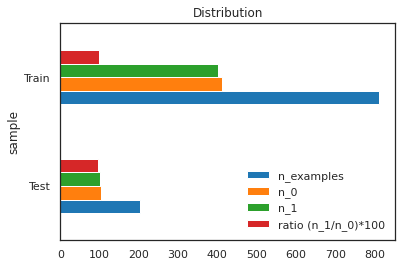

In [ ]:
df_distribution.plot(y=['n_examples', 'n_0', 'n_1', 'ratio (n_1/n_0)*100'], kind='barh', title='Distribution')

In [ ]:
data.head(5).to_latex()

"\\begin{tabular}{lrrlllllr}\n\\toprule\n{} &  id &  like &                                              title &                                           overview &                                             genres &                                               crew &                                               cast &  n\\_words \\\\\n\\midrule\n0 &  11 &     1 &  La guerra de las galaxias. Episodio IV: Una nu... &  La princesa Leia, líder del movimiento rebelde... &  [\\{'id': 12, 'name': 'Aventura'\\}, \\{'id': 28, 'n... &  [\\{'credit\\_id': '52fe420dc3a36847f8000437', 'de... &  [\\{'cast\\_id': 3, 'character': 'Luke Skywalker',... &       87 \\\\\n1 &  62 &     1 &                       2001: Una odisea del espacio &  La historia de la humanidad, en diversos estad... &  [\\{'id': 878, 'name': 'Ciencia ficción'\\}, \\{'id'... &  [\\{'credit\\_id': '52fe4212c3a36847f8001a05', 'de... &  [\\{'cast\\_id': 6, 'character': 'Dr. David Bowman... &      104 \\\\\n2 &  74 &     1 &      

# Vectorize text

We are going to vectorize the overviews using a method call Bag of word (https://es.wikipedia.org/wiki/Modelo_bolsa_de_palabras). We have a vector for each sentence which consists in a vector with the lenght of the total vocabulary of the overviews, and have the count of how many times the word is appearing in this overview in concrete.

We obtain a very sparse matrix that we will see how to deal with in the next experiments.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(lowercase=False)
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)
#X_val = vectorizer.transform(X_val)

In [ ]:
len(vectorizer.vocabulary_)

11499

In [ ]:
#vectorizer.vocabulary_
#{k: v for k, v in sorted(x.items(), key=lambda item: item[1])}

# Deep learning model

Let's give it a try with a very simple neural network with the input and 2 dense layers.
- Input Layer: its the input of the neural network, batch with dimension of 10146.
- Dense Layer 1: recieve the input and returns 2 dimensions (only have 2 neurons fully conected to the input).
- Dense Layer 2: recieve the 2 previous dimensions and return 1 value with the probability between 0 and 1.

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

input_dim = X_train.shape[1]  # Number of features

# Test with Sequential Model 

model = Sequential()
model.add(layers.Dense(25, input_dim=input_dim, 
                       activation='relu',
                       name='dense_1'))
model.add(layers.Dense(1, activation='sigmoid', name='dense_2'))

Parameters of the model

In [63]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                287500    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 287,526
Trainable params: 287,526
Non-trainable params: 0
_________________________________________________________________


In [64]:
#(input * weights_dense_1 + bias_dense_1) + (output_dense_1 * weights_dense_2 + bias_dense_2)

parameters_dense_1 = (10146 * 2 + 2)
parameters_dense_2 = (2 * 1 + 1)
total_parameters =  parameters_dense_1 + parameters_dense_2
total_parameters

20297

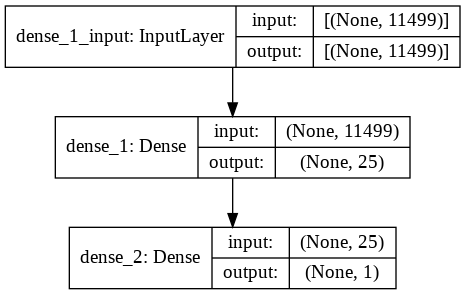

In [65]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [66]:
epochs = 8
batch_size = 4

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=batch_size)

Epoch 1/8
203/203 [==============================] - 1s 4ms/step - loss: 0.6951 - accuracy: 0.4614 - val_loss: 0.6743 - val_accuracy: 0.5911
Epoch 2/8
203/203 [==============================] - 1s 4ms/step - loss: 0.6258 - accuracy: 0.8552 - val_loss: 0.6389 - val_accuracy: 0.7635
Epoch 3/8
203/203 [==============================] - 1s 4ms/step - loss: 0.5444 - accuracy: 0.9488 - val_loss: 0.5977 - val_accuracy: 0.7931
Epoch 4/8
203/203 [==============================] - 1s 4ms/step - loss: 0.4483 - accuracy: 0.9676 - val_loss: 0.5547 - val_accuracy: 0.8325
Epoch 5/8
203/203 [==============================] - 1s 4ms/step - loss: 0.3621 - accuracy: 0.9921 - val_loss: 0.5188 - val_accuracy: 0.8227
Epoch 6/8
203/203 [==============================] - 1s 4ms/step - loss: 0.2812 - accuracy: 0.9913 - val_loss: 0.4927 - val_accuracy: 0.8374
Epoch 7/8
203/203 [==============================] - 1s 4ms/step - loss: 0.2490 - accuracy: 0.9955 - val_loss: 0.4676 - val_accuracy: 0.8325
Epoch 8/8
203

During training the neural network try to optimize the error (Gradient descent). Loss value is going to be lower each interaction until overfitting of training dataset.

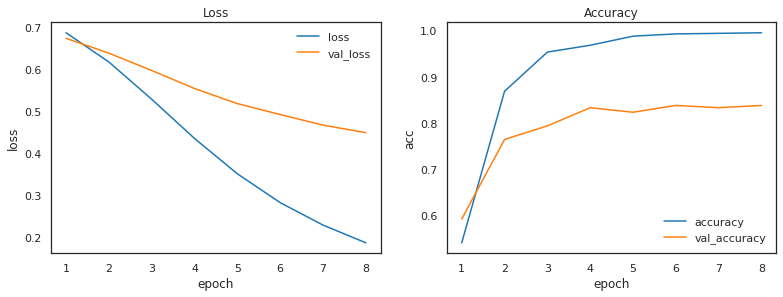

In [67]:
#Plot history

fit_history = pd.DataFrame(history.history)
fit_history['epoch'] = fit_history.index + 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.25))
fit_history.plot(x='epoch', y=['loss', 'val_loss'], kind='line', ylabel='loss', title='Loss', ax=ax1)
fit_history.plot(x='epoch', y=['accuracy', 'val_accuracy'], kind='line', ylabel='acc', title='Accuracy', ax=ax2)

# Metrics
The metrics are very important in order to select the better model. (Andrew NG Book). This is a classification problem so we have to chose clasification metrics. https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

We are going to consider the following metrics in order to compare the following models:
- Accuracy: https://developers.google.com/machine-learning/crash-course/classification/accuracy
- AUC: Area under the ROC Curve. https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

Other metrics to consider could be:
- Precision
- Recall
- F1-score

Hands on Machine Learning (Bibliografy)

In [68]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_true = y_test

print('Acc: ' + str(accuracy_score(y_true, y_pred).round(4)))
print('Precision: ' + str(precision_score(y_true, y_pred).round(4)))
print('Recall: ' + str(recall_score(y_true, y_pred).round(4)))
print('F1: ' + str(f1_score(y_true, y_pred).round(4)))
print('Conf. Matrix: ')
print(confusion_matrix(y_true, y_pred))

Acc: 0.8374
Precision: 0.9036
Recall: 0.75
F1: 0.8197
Conf. Matrix: 
[[95  8]
 [25 75]]


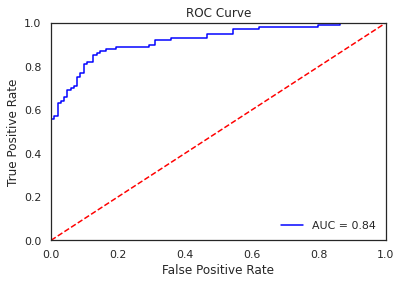

AUC: 0.8362


In [69]:
y_pred_keras = model.predict(X_test).flatten()
fpr, tpr, thresholds = roc_curve(y_true, y_pred_keras)
roc_auc = roc_auc_score(y_true, y_pred)

def plot_roc_curve(fpr,tpr): 
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()   
  
plot_roc_curve(fpr,tpr) 
print('AUC: ' + str(roc_auc.round(4)))

# Original Metrics results:

- Vocabulary: 16994
- Accuracy: 84%
- AUC: 84%
- Precision: 90%
- Recall: 75%
- F1: 82%

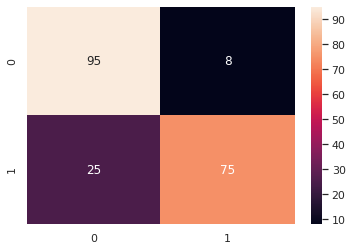

In [76]:
matrix_con = confusion_matrix(y_true, y_pred)
sns.heatmap(matrix_con, annot=True)

In [133]:
df_results = pd.DataFrame(columns=['Experimento', 'N palabras', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1'])

new_row = {'Experimento': 'Orig. + BOW + Dense','N palabras': 16994,'Accuracy':84, 'AUC':84, 'Precision':90, 'Recall':75, 'F1':82}
df_results = df_results.append(new_row, ignore_index=True)

new_row = {'Experimento': 'Stem. + BOW + Dense','N palabras': 7939,'Accuracy':87, 'AUC':87, 'Precision':89, 'Recall':85, 'F1':87}
df_results = df_results.append(new_row, ignore_index=True)

new_row = {'Experimento': 'Text Aug. + Stem. + BOW + Dense','N palabras': 10000,'Accuracy':88, 'AUC':88, 'Precision':90, 'Recall':86, 'F1':88}
df_results = df_results.append(new_row, ignore_index=True)

new_row = {'Experimento': 'Word Emb. + CNN','N palabras': 10000,'Accuracy':90, 'AUC':90, 'Precision':90, 'Recall':86, 'F1':88}
df_results = df_results.append(new_row, ignore_index=True)

df_results

,Experimento,N palabras,Accuracy,AUC,Precision,Recall,F1
0,Orig. + BOW + Dense,16994,84,84,90,75,82
1,Stem. + BOW + Dense,7939,87,87,89,85,87
2,Text Aug. + Stem. + BOW + Dense,10000,88,88,90,86,88
3,Word Emb. + CNN,10000,90,90,90,86,88


Vocabulary

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

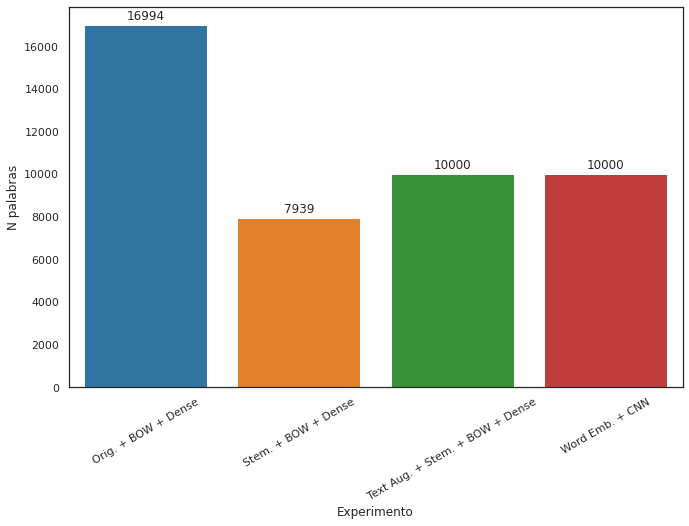

In [145]:
fig, ax = plt.subplots(figsize=(11, 7))
splot = sns.barplot(x="Experimento", y="N palabras", data=df_results, ax=ax)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=30)

Vocabulary vs acc

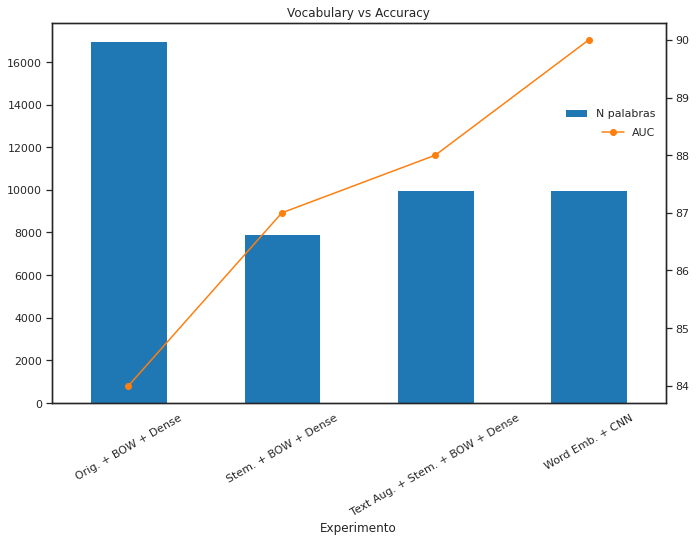

In [150]:
fig, ax1 = plt.subplots(figsize=(11, 7))
df_results.plot(kind='bar', x='Experimento', y='N palabras', title='Vocabulary vs Accuracy', rot=30, ax=ax1).legend(bbox_to_anchor=(1,0.80), loc="upper right")
ax2 = ax1.twinx()
df_results.plot(kind='line', x='Experimento', y='AUC', color='tab:orange', marker='o', secondary_y=True, ax=ax2, legend=False).legend(bbox_to_anchor=(1,0.75), loc="upper right")

Metrics

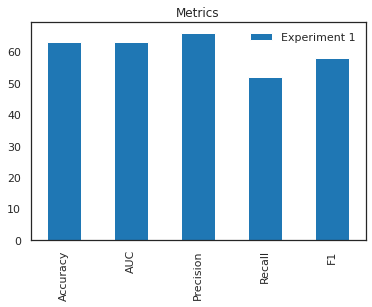

In [ ]:
df_results.iloc[1:].plot(kind='bar', title='Metrics')